# ==== INTERACTIVE CLUSTERING : ANNOTATION ERROR STUDY ====
> ### Stage 3 : Modelize annotation errors impact on Interactive Clustering and Plot some figures.

------------------------------
## READ-ME BEFORE RUNNING

### Quick Description

This notebook is **aimed at modelize annotation errors impact during interactive clusterings, plot overviews of experiments**.
- Environments are represented by subdirectories in the `/experiments` folder. A full path to an experiment environment is `/experiments/[DATASET]/[CLUSTERING]/[CONSTRAINTS_SELECTION]/[ERRORS_SIMULATION]`.

Before running, **run the notebook `2_Simulate_errors_and_run_clustering.ipynb` on each algorithm you have set**.

### Description each steps

First of all, **load experiments** that have been computed with the last notebook.
- A config file contains parameters used for each experiment and annotation error simulations to analyze.
- For each algorithm and constraints selection method, print performance evolution according to constraints number and error rate.

- Several parameters are studied depending on the task:
    - _preprocessing_: `dataset_size`, `algorithm_name`;
    - _vectorization_: `dataset_size`, `algorithm_name`;
    - _sampling_: `dataset_size`, `algorithm_name`, `previous_nb_constraints`, `previous_nb_clusters`, `algorithm_nb_to_select`;
    - _clustering_: `dataset_size`, `algorithm_name`, `previous_nb_constraints`, `previous_nb_clusters`.
- Two random effects are used : `dataset_random_seed`, `algorithm_random_seed`.
- One values is modelized with these factors : `time_total`.

Then, for each task :
1. Compute interactions of factors (`1`, `X1`, `X1²`, `X1*X2`, ...)
2. Sort interactions by correlation in order to choose a efficient modelization of computation time
3. Compute Generalized Linear Model to get the modelization parameters
4. Plot modelized computation time

------------------------------

## 1. IMPORT PYTHON DEPENDENCIES

In [1]:
from typing import Dict, List, Optional, Tuple, Union
import json
import listing_envs
import numpy as np
import openpyxl
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy import stats as scipystats
import statistics
import statsmodels
import statsmodels.api
import statsmodels.formula.api

------------------------------

## 2. Load data

In [2]:
# Get list of experiment environments.
LIST_OF_EXPERIMENT_ENVIRONMENTS: List[
    str
] = listing_envs.get_list_of_errors_simulation_env_paths()
print(
    "There are",
    "`" + str(len(LIST_OF_EXPERIMENT_ENVIRONMENTS)) + "`",
    "created experiment environments in `../experiments`",
)
LIST_OF_EXPERIMENT_ENVIRONMENTS

There are `220000` created experiment environments in `../experiments`


['../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_1-without_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_1-with_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_10-without_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_10-with_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_2-without_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_2-with_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_3-without_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_3-with_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_4-without_fix/',
 '../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_4-with_

In [3]:
df_simulations = pd.read_csv("../results/experiments_synthesis.csv", sep=";", index_col=0)
df_simulations["error_simulation__error_rate"] = df_simulations["error_simulation__error_rate"].str.replace(",", ".").astype(float)
df_simulations["clustering__v_measure"] = df_simulations["clustering__v_measure"].str.replace(",", ".").astype(float)
df_simulations["clustering__homogeneity"] = df_simulations["clustering__homogeneity"].str.replace(",", ".").astype(float)
df_simulations["clustering__completeness"] = df_simulations["clustering__completeness"].str.replace(",", ".").astype(float)
df_simulations.head()

,dataset,algorithm,constraints_selection,error_simulation,constraints_selection__algorithm,constraints_selection__number,constraints_selection__random_seed,error_simulation__error_rate,error_simulation__random_seed,error_simulation__with_fix,constraints__annotated,constraints__MUST_LINK,constraints__CANNOT_LINK,constraints__errors,constraints__conflicts,clustering__v_measure,clustering__homogeneity,clustering__completeness
../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_1-without_fix/,bank_cards_v1,tfidf_cop_with_kmeans,nb_100-closest_1,rate_0.00-rand_1-without_fix,closest_in_different_clusters,100,1,0.0,1,False,100,76,24,0,0,0.327658,0.313544,0.343102
../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_1-with_fix/,bank_cards_v1,tfidf_cop_with_kmeans,nb_100-closest_1,rate_0.00-rand_1-with_fix,closest_in_different_clusters,100,1,0.0,1,True,100,76,24,0,0,0.327658,0.313544,0.343102
../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_10-without_fix/,bank_cards_v1,tfidf_cop_with_kmeans,nb_100-closest_1,rate_0.00-rand_10-without_fix,closest_in_different_clusters,100,1,0.0,10,False,100,76,24,0,0,0.327658,0.313544,0.343102
../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_10-with_fix/,bank_cards_v1,tfidf_cop_with_kmeans,nb_100-closest_1,rate_0.00-rand_10-with_fix,closest_in_different_clusters,100,1,0.0,10,True,100,76,24,0,0,0.327658,0.313544,0.343102
../experiments/bank_cards_v1/tfidf_cop_with_kmeans/nb_100-closest_1/rate_0.00-rand_2-without_fix/,bank_cards_v1,tfidf_cop_with_kmeans,nb_100-closest_1,rate_0.00-rand_2-without_fix,closest_in_different_clusters,100,1,0.0,2,False,100,76,24,0,0,0.327658,0.313544,0.343102


------------------------------

## 3. Display evolution of performances according to errors simulations

In [4]:
def get_MEAN_SEM_of_performance_evolution_per_constraints_number(
    local_LIST_OF_EXPERIMENT_ENVIRONMENTS,
) -> Tuple[Dict[str, float], Dict[str, float], Dict[str, float]]:
    """
    Compute evolution of performance accross constraints number.
    Return Mean and Standard error of the mean evolutions
    
    Args:
        - local_LIST_OF_EXPERIMENT_ENVIRONMENTS (List[str]): The list of experiments to consider.
    Returns:
        Tuple[Dict[str, float], Dict[str, float]]: Evolutions of Mean and Standard error of the mean accross constraints number.
    """

    # Initialize storage of experiment performances for all constraints number.
    dict_of_global_performances_evolution_per_constraints_number: Dict[int, List[float]] = {}
    # Initialize storage of performance mean for all constraints number.
    dict_of_global_performances_evolution_per_constraints_number_MEAN: Dict[int, float] = {}
    # Initialize storage of performance standard error of the mean for all constraints number.
    dict_of_global_performances_evolution_per_constraints_number_SEM: Dict[int, float] = {}

    # For each experiment...
    for env_a in local_LIST_OF_EXPERIMENT_ENVIRONMENTS:
        
        # Get number of annotated constraints
        with open(
            env_a + "../config.json", "r"
        ) as config_file:
            nb_constraints: float = json.load(config_file)["nb_constraints"]

        # Load clustering evaluations.
        with open(
            env_a + "dict_of_clustering_performances.json", "r"
        ) as evaluation_file:
            dict_of_clustering_performances: Dict[str, float] = json.load(evaluation_file)

        # For each requested iteration...
        if nb_constraints not in dict_of_global_performances_evolution_per_constraints_number.keys():
            dict_of_global_performances_evolution_per_constraints_number[nb_constraints] = []
        dict_of_global_performances_evolution_per_constraints_number[nb_constraints].append(dict_of_clustering_performances["v_measure"])

    # Compute mean and sem of performance for each constraints number.
    for x in dict_of_global_performances_evolution_per_constraints_number.keys():

        # Compute mean of performance for this constraints number.
        dict_of_global_performances_evolution_per_constraints_number_MEAN[x] = np.mean(dict_of_global_performances_evolution_per_constraints_number[x])
        # Compute sem of performance for this constraints number.
        dict_of_global_performances_evolution_per_constraints_number_SEM[x] = scipystats.sem(dict_of_global_performances_evolution_per_constraints_number[x])
        
    # Return.
    return (
        dict_of_global_performances_evolution_per_constraints_number_MEAN,
        dict_of_global_performances_evolution_per_constraints_number_SEM
    )

In [5]:
def add_plot_of_performance_evolution_per_constraints_number_to_graph(
    axis,
    list_of_x: List[int],
    dict_of_y: Dict[int, float],
    dict_of_y_err: Optional[Dict[int, float]] = None,
    label: str = "",
    label_in_curve: Optional[str] = None,
    marker: str = "",
    markersize: int = 5,
    color: str = "black",
    linewidth: int = 2,
    linestyle: str = "-",
    alpha: float = 0.2,
):
    """
    Add a plot to an axis of a graph.
    
    Args:
        - axis (): TODO.
        - list_of_x (List[str]): TODO.
        - dict_of_y (Dict[str, float]): TODO.
        - dict_of_y_err (Optional[Dict[str, float]]): TODO. Defaults to `None`.
        - label (str): TODO. Defaults to `""`.
        - label_in_curve (Optional[str]): TODO. Defaults to `None`.
        - marker (str): TODO. Defaults to `""`.
        - markersize (int): TODO. Defaults to `5`.
        - color (str): TODO. Defaults to `"black"`.
        - linewidth (int): TODO. Defaults to `2`.
        - linestyle (str): TODO. Defaults to `"-"`.
        - alpha (float): TODO. Defaults to `0.2`.
    """
    # Add curve.
    axis.plot(
        [float(x) for x in list_of_x],  # x
        [dict_of_y[x] for x in list_of_x],  # y
        label=label,
        marker=marker,
        markerfacecolor=color,
        markersize=markersize,
        color=color,
        linewidth=linewidth,
        linestyle=linestyle,
    )
    # Add curve name.
    if label_in_curve is not None:
        axis.text(
            x=list_of_x[-1],
            y=dict_of_y[list_of_x[-1]],
            s=label_in_curve,
        )
    # Add curve error bars.
    if dict_of_y_err is not None:
        axis.fill_between(
            [float(x) for x in list_of_x],  # x
            y1=[(dict_of_y[x] - dict_of_y_err[x]) for x in list_of_x],  # y1
            y2=[(dict_of_y[x] + dict_of_y_err[x]) for x in list_of_x],  # y2
            color=color,
            alpha=alpha,
        )

Define configuration for graphs.

In [6]:
MAX_NB_CONSTRAINTS_TO_PLOT: int = 3500

In [7]:
LIST_OF_ERROR_RATES: List[float] = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]

In [8]:
# Config for makers.
markers: Dict[float, str] = {error_rate: "." for error_rate in LIST_OF_ERROR_RATES}
markers[0.00] = "^"
markers[0.50] = "v"
# Config for maker sizes.
markersizes: Dict[float, int] = {error_rate: 3 for error_rate in LIST_OF_ERROR_RATES}
markersizes[0.00] = 5
markersizes[0.50] = 5
# Config for linewidths.
linewidths: Dict[float, int] = {error_rate: 0.5 for error_rate in LIST_OF_ERROR_RATES}
linewidths[0.00] = 1
linewidths[0.50] = 1
# Config for linestyles.
linestyles: Dict[float, str] = {error_rate: "--" for error_rate in LIST_OF_ERROR_RATES}
linestyles[0.00] = "-"
linestyles[0.50] = "-"

### 3.1. Modelization of `random` `with_fix=False`.

In [9]:
# Fit the model to the data and print results.
model_simulation_random_without_fix = statsmodels.formula.api.glm(
    formula="clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate",
    data=df_simulations[
        (df_simulations["constraints_selection__algorithm"]=="random")
        &(df_simulations["error_simulation__with_fix"]==False)
    ],
)
results_simulation_random_without_fix = model_simulation_random_without_fix.fit()
print("==============================================================================")
print(">>> formula:", model_simulation_random_without_fix.formula)
print("==============================================================================")
print(results_simulation_random_without_fix.summary())

>>> formula: clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate
                   Generalized Linear Model Regression Results                   
Dep. Variable:     clustering__v_measure   No. Observations:                82500
Model:                               GLM   Df Residuals:                    82496
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                        0.015476
Method:                             IRLS   Log-Likelihood:                 54890.
Date:                   Mon, 12 Jun 2023   Deviance:                       1276.7
Time:                           17:30:11   Pearson chi2:                 1.28e+03
No. Iterations:                        3   Pseudo R-squ. (CS):             0.7316
Covariance Type:               nonrobust                                         
                                                          coef    std err          z   

In [10]:
print(
    "random.without_fix ~",
    "{0:.2E}".format(results_simulation_random_without_fix.params["Intercept"]),
    "+ {0:.2E}*constraints_number".format(results_simulation_random_without_fix.params["constraints__annotated"]),
    "+ {0:.2E}*error_rate".format(results_simulation_random_without_fix.params["error_simulation__error_rate"]),
    #"+ {0:.2E}*(constraints_number*error_rate)".format(results_simulation_random_without_fix.params["constraints__annotated:error_simulation__error_rate"]),
)

random.without_fix ~ 3.50E-01 + 2.18E-05*constraints_number + -5.37E-01*error_rate


In [11]:
# Define the interpolation function.
def interpolation_random_without_fix(constraints_number, error_rate) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (results_simulation_random_without_fix.params["Intercept"] - results_simulation_random_without_fix.bse["Intercept"])
    res += results_simulation_random_without_fix.params["Intercept"]
    res_high += (results_simulation_random_without_fix.params["Intercept"] + results_simulation_random_without_fix.bse["Intercept"])
    # constraints__annotated.
    res_low += (results_simulation_random_without_fix.params["constraints__annotated"] - results_simulation_random_without_fix.bse["constraints__annotated"]) * constraints_number
    res += results_simulation_random_without_fix.params["constraints__annotated"] * constraints_number
    res_high += (results_simulation_random_without_fix.params["constraints__annotated"] + results_simulation_random_without_fix.bse["constraints__annotated"]) * constraints_number
    # error_simulation__error_rate.
    res_low += (results_simulation_random_without_fix.params["error_simulation__error_rate"] - results_simulation_random_without_fix.bse["error_simulation__error_rate"]) * error_rate
    res += results_simulation_random_without_fix.params["error_simulation__error_rate"] * error_rate
    res_high += (results_simulation_random_without_fix.params["error_simulation__error_rate"] + results_simulation_random_without_fix.bse["error_simulation__error_rate"]) * error_rate
    # constraints__annotated:error_simulation__error_rate.
    #res_low += (results_simulation_random_without_fix.params["constraints__annotated:error_simulation__error_rate"] - results_simulation_random_without_fix.bse["constraints__annotated:error_simulation__error_rate"]) * (constraints_number*error_rate)
    #res += results_simulation_random_without_fix.params["constraints__annotated:error_simulation__error_rate"] * (constraints_number*error_rate)
    #res_high += (results_simulation_random_without_fix.params["constraints__annotated:error_simulation__error_rate"] + results_simulation_random_without_fix.bse["constraints__annotated:error_simulation__error_rate"]) * (constraints_number*error_rate)
    # Return.
    return res_low, res, res_high

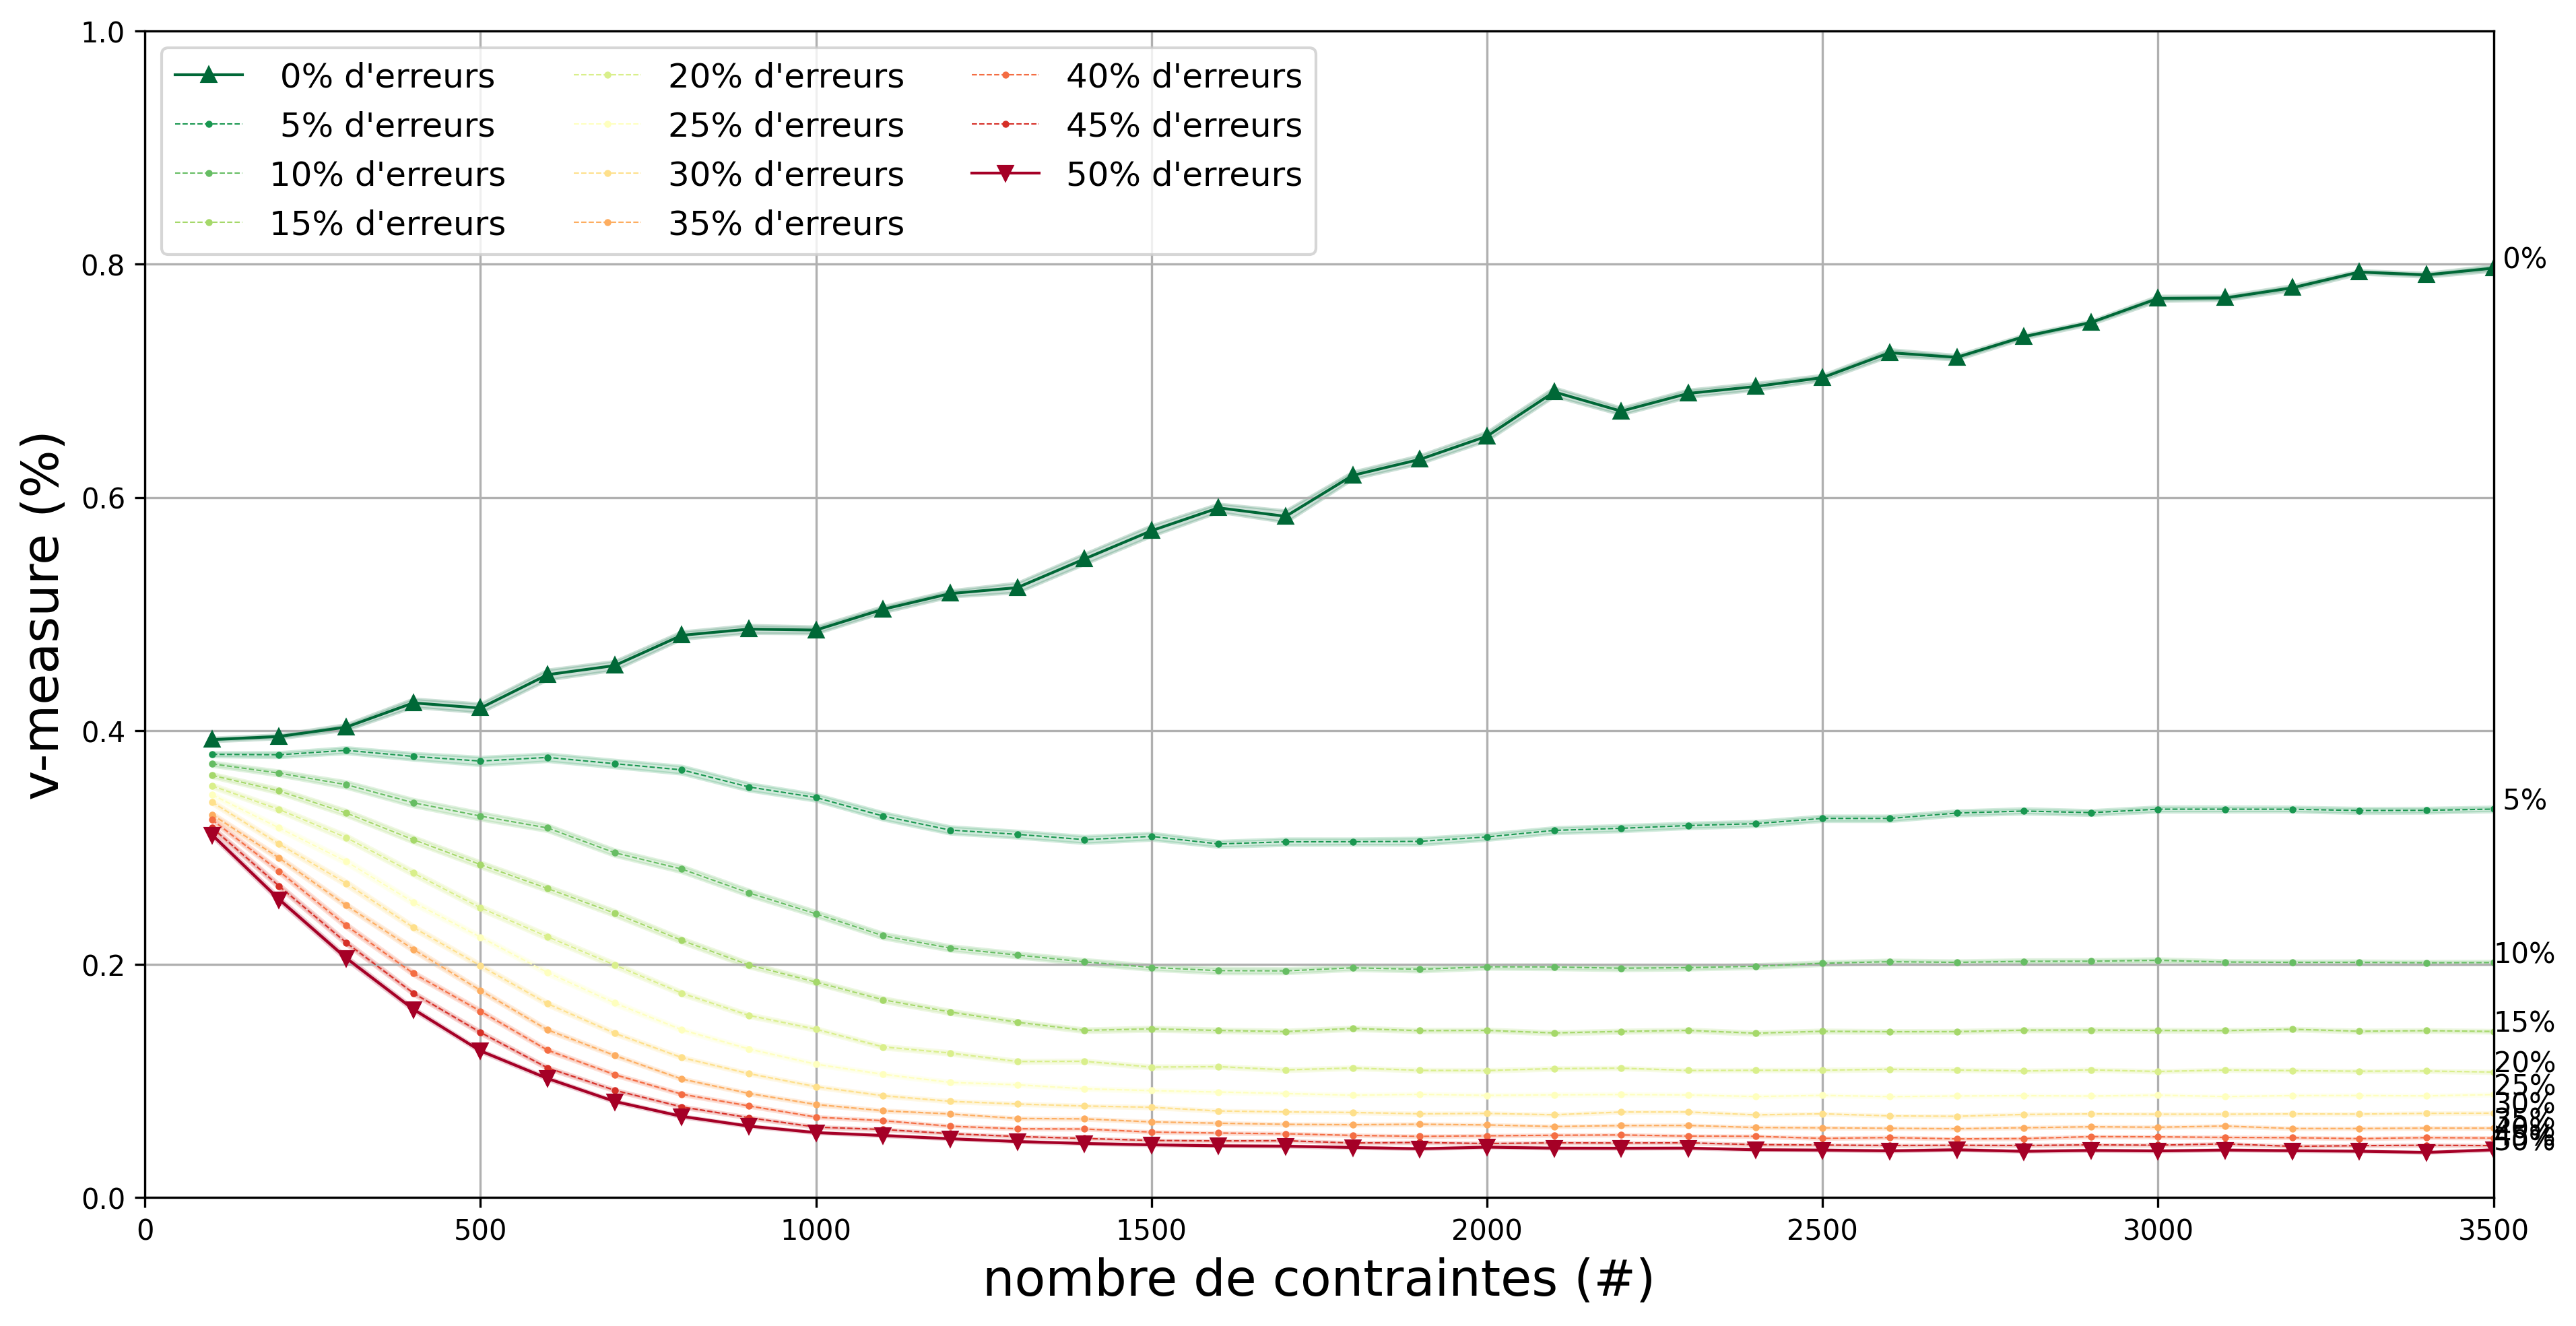

In [12]:
# Create a new figure.
fig_plot_error_simulation_random_without_fix: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_error_simulation_random_without_fix = fig_plot_error_simulation_random_without_fix.gca()

# Set range of axis.
axis_plot_error_simulation_random_without_fix.set_xlim(xmin=0, xmax=MAX_NB_CONSTRAINTS_TO_PLOT)
axis_plot_error_simulation_random_without_fix.set_ylim(ymin=0, ymax=1)

# Define color map.
list_of_colors = matplotlib.colormaps["RdYlGn"](
    np.linspace(1, 0, len(LIST_OF_ERROR_RATES))
)
    
# Plot error simulation.
for k, error_rate_k in enumerate(LIST_OF_ERROR_RATES):
        
    # Compute performance MEAN and SEM for this error rate.
    performances_random_without_fix_MEAN, performances_random_without_fix_SEM = get_MEAN_SEM_of_performance_evolution_per_constraints_number(
        local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
            env
            for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
            if (
                "-rand_" in env.split("/")[4]
                and "{rate:.2f}".format(rate=error_rate_k) in env.split("/")[5]
                and "-without_fix" in env.split("/")[5]
            )
        ],
    )
    
    # Add plot.
    add_plot_of_performance_evolution_per_constraints_number_to_graph(
        axis=axis_plot_error_simulation_random_without_fix,
        list_of_x=[
            constraints_number
            for constraints_number in sorted(performances_random_without_fix_MEAN.keys())
            if constraints_number <= MAX_NB_CONSTRAINTS_TO_PLOT
        ],
        dict_of_y=performances_random_without_fix_MEAN,
        dict_of_y_err=performances_random_without_fix_SEM,
        label="{rate:2d}% d'erreurs".format(rate=int(error_rate_k*100)),
        label_in_curve="{rate:2d}%".format(rate=int(error_rate_k*100)),
        marker=markers[error_rate_k],
        markersize=markersizes[error_rate_k],
        color=list_of_colors[k],
        linewidth=linewidths[error_rate_k],
        linestyle=linestyles[error_rate_k],
        alpha=0.2,
    )

    # Add modelization plot.
    #add_plot_of_performance_evolution_per_constraints_number_to_graph(
    #    axis=axis_plot_error_simulation_random_without_fix,
    #    list_of_x=[
    #        constraints_number
    #        for constraints_number in sorted(performances_random_without_fix_MEAN.keys())
    #        if constraints_number <= MAX_NB_CONSTRAINTS_TO_PLOT
    #    ],
    #    dict_of_y={
    #        constraints_number: interpolation_random_without_fix(constraints_number, error_rate_k)[1]
    #        for constraints_number in sorted(performances_random_without_fix_MEAN.keys())
    #        if constraints_number <= MAX_NB_CONSTRAINTS_TO_PLOT
    #    },
    #    dict_of_y_err=None,
    #    label=None,
    #    label_in_curve=None,
    #    marker="",
    #    markersize=markersizes[error_rate_k],
    #    color="black",
    #    linewidth=linewidths[error_rate_k],
    #    linestyle=linestyles[error_rate_k],
    #    alpha=0.2,
    #)

# Set axis name.
axis_plot_error_simulation_random_without_fix.set_xlabel("nombre de contraintes (#)", fontsize=18,)
axis_plot_error_simulation_random_without_fix.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_error_simulation_random_without_fix.legend(
    ncol=3,
    loc="upper left",
    fontsize=12,
)

# Plot the grid.
axis_plot_error_simulation_random_without_fix.grid(True)
    
# Store the graph.
fig_plot_error_simulation_random_without_fix.savefig(
    "../results/etude-erreur-simulation-impact-1random-without-fix.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Modelization of `closest_in_different_clusters` `with_fix=False`.

In [13]:
# Fit the model to the data and print results.
model_simulation_closest_without_fix = statsmodels.formula.api.glm(
    formula="clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate",
    data=df_simulations[
        (df_simulations["constraints_selection__algorithm"]=="closest_in_different_clusters")
        &(df_simulations["error_simulation__with_fix"]==False)
    ],
)
results_simulation_closest_without_fix = model_simulation_closest_without_fix.fit()
print("==============================================================================")
print(">>> formula:", model_simulation_closest_without_fix.formula)
print("==============================================================================")
print(results_simulation_closest_without_fix.summary())

>>> formula: clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate
                   Generalized Linear Model Regression Results                   
Dep. Variable:     clustering__v_measure   No. Observations:                27500
Model:                               GLM   Df Residuals:                    27496
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                        0.013549
Method:                             IRLS   Log-Likelihood:                 20126.
Date:                   Mon, 12 Jun 2023   Deviance:                       372.55
Time:                           17:36:49   Pearson chi2:                     373.
No. Iterations:                        3   Pseudo R-squ. (CS):             0.9566
Covariance Type:               nonrobust                                         
                                                          coef    std err          z   

In [14]:
print(
    "random.without_fix ~",
    "{0:.2E}".format(results_simulation_closest_without_fix.params["Intercept"]),
    "+ {0:.2E}*constraints_number".format(results_simulation_closest_without_fix.params["constraints__annotated"]),
    "+ {0:.2E}*error_rate".format(results_simulation_closest_without_fix.params["error_simulation__error_rate"]),
)

random.without_fix ~ 4.96E-01 + 8.55E-05*constraints_number + -5.91E-01*error_rate


In [15]:
# Define the interpolation function.
def interpolation_closest_without_fix(constraints_number, error_rate) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (results_simulation_closest_without_fix.params["Intercept"] - results_simulation_closest_without_fix.bse["Intercept"])
    res += results_simulation_closest_without_fix.params["Intercept"]
    res_high += (results_simulation_closest_without_fix.params["Intercept"] + results_simulation_closest_without_fix.bse["Intercept"])
    # constraints__annotated.
    res_low += (results_simulation_closest_without_fix.params["constraints__annotated"] - results_simulation_closest_without_fix.bse["constraints__annotated"]) * constraints_number
    res += results_simulation_closest_without_fix.params["constraints__annotated"] * constraints_number
    res_high += (results_simulation_closest_without_fix.params["constraints__annotated"] + results_simulation_closest_without_fix.bse["constraints__annotated"]) * constraints_number
    # error_simulation__error_rate.
    res_low += (results_simulation_closest_without_fix.params["error_simulation__error_rate"] - results_simulation_closest_without_fix.bse["error_simulation__error_rate"]) * error_rate
    res += results_simulation_closest_without_fix.params["error_simulation__error_rate"] * error_rate
    res_high += (results_simulation_closest_without_fix.params["error_simulation__error_rate"] + results_simulation_closest_without_fix.bse["error_simulation__error_rate"]) * error_rate
    # Return.
    return res_low, res, res_high

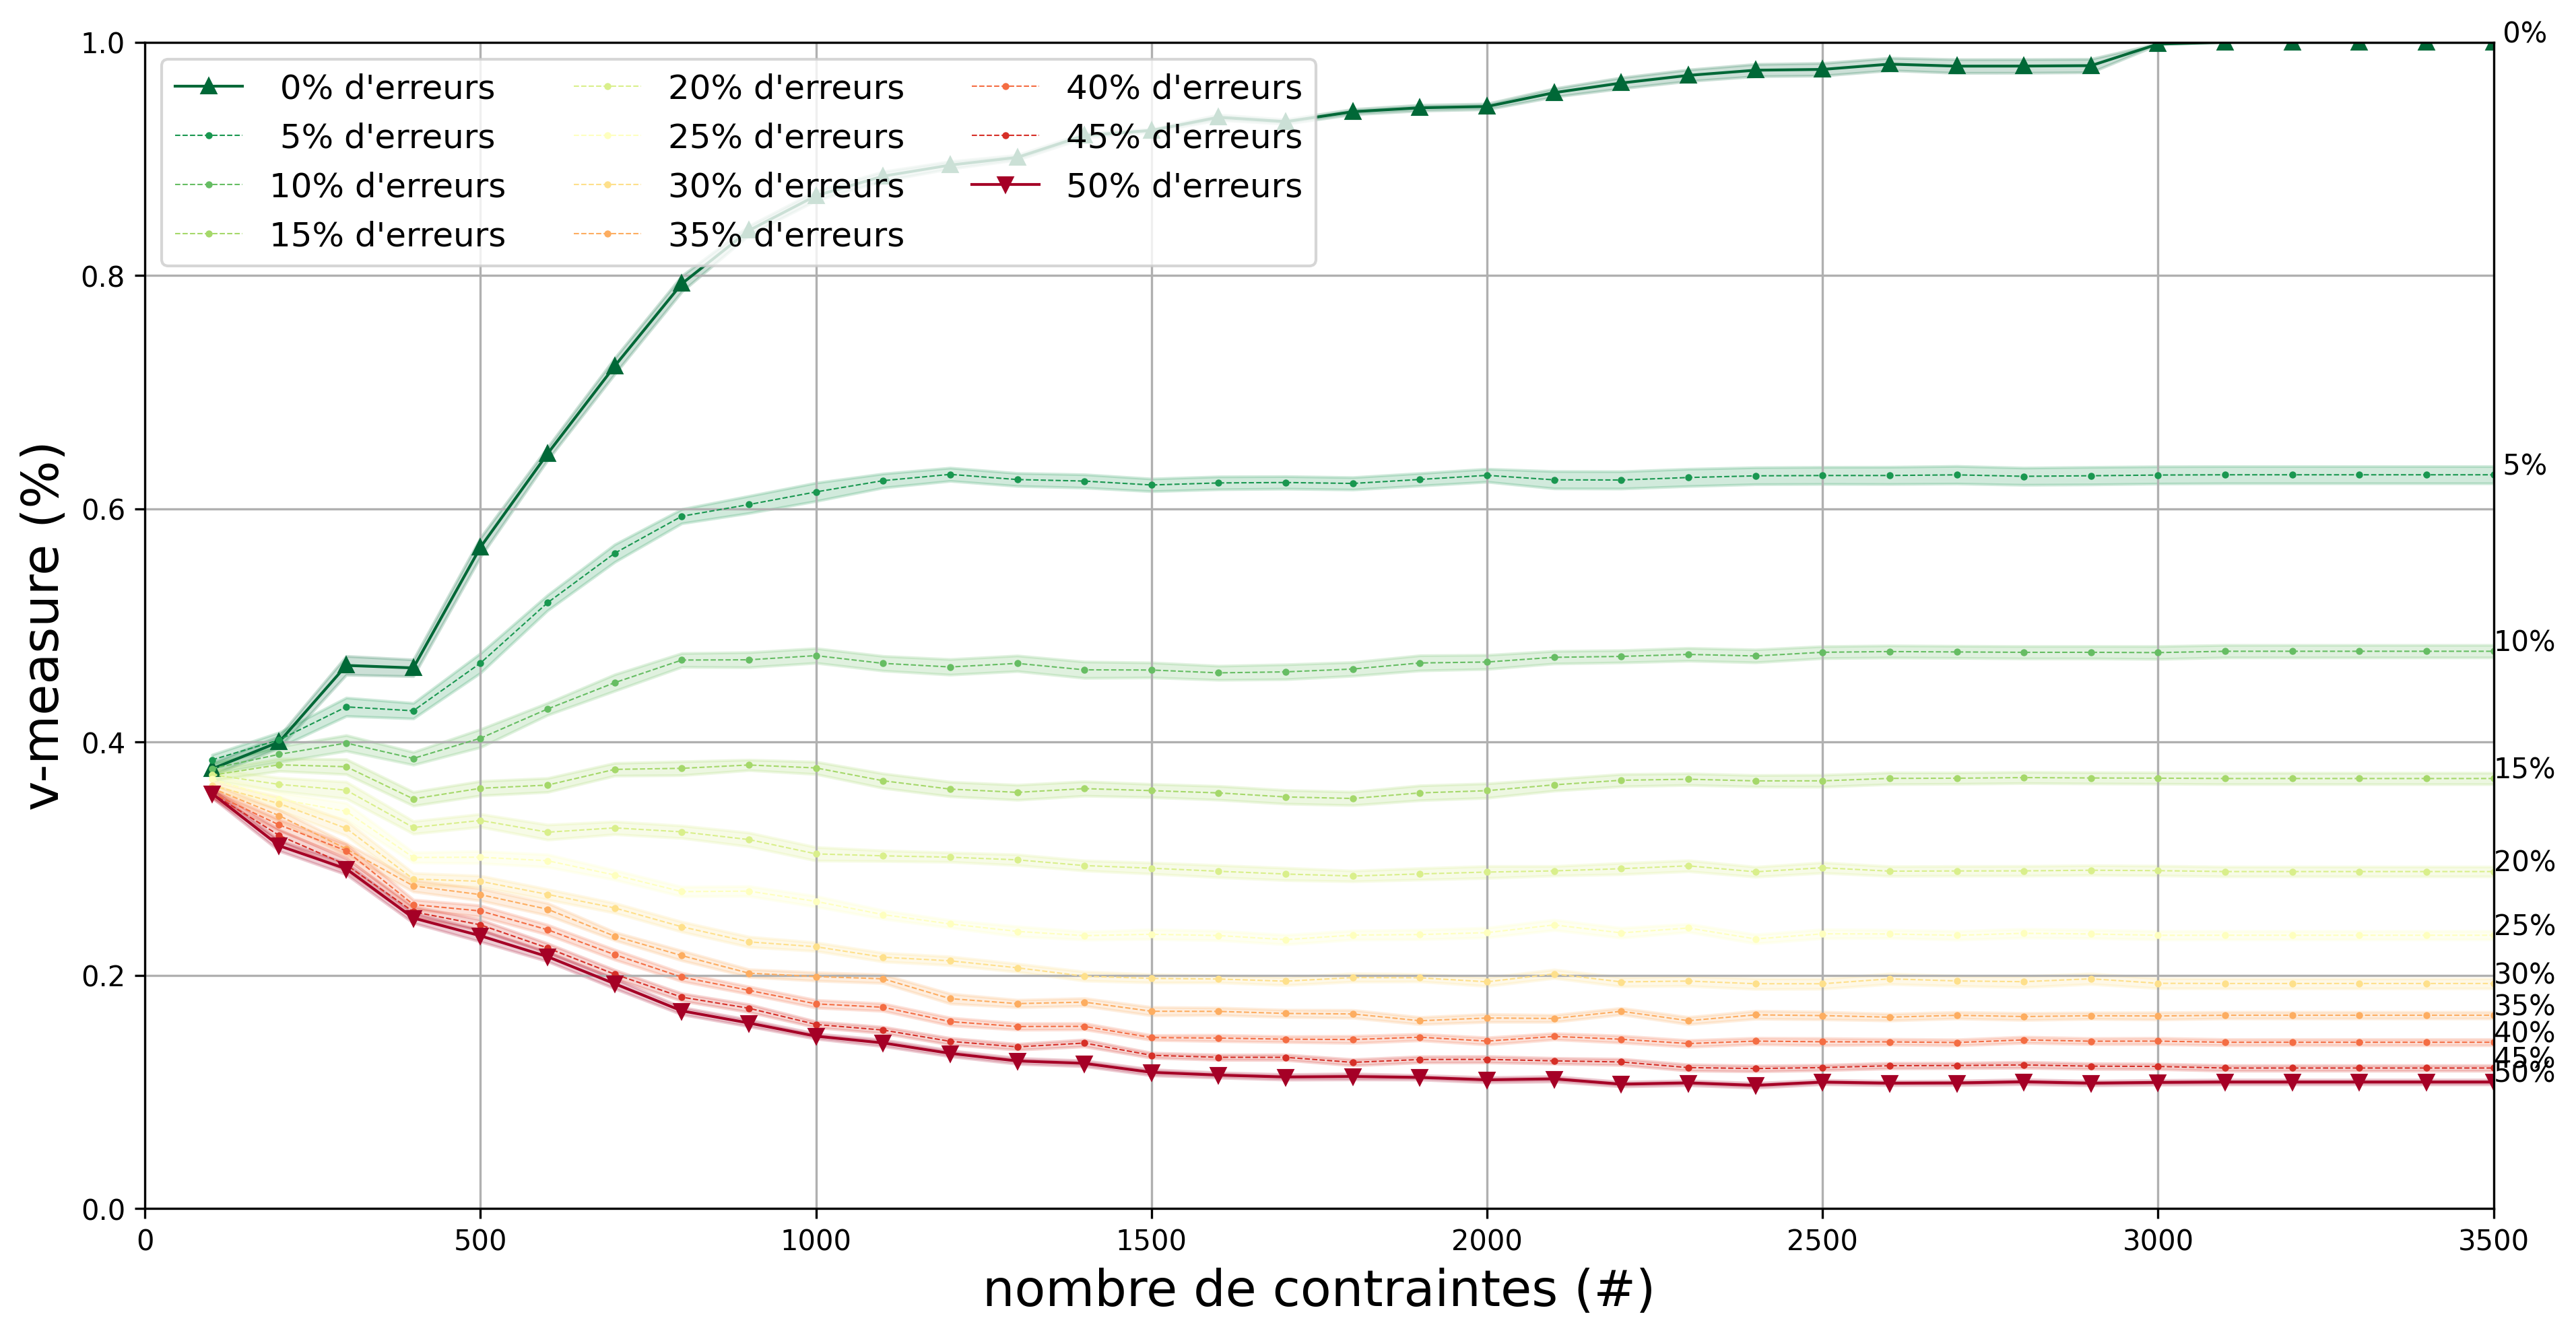

In [16]:
# Create a new figure.
fig_plot_error_simulation_closest_without_fix: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_error_simulation_closest_without_fix = fig_plot_error_simulation_closest_without_fix.gca()

# Set range of axis.
axis_plot_error_simulation_closest_without_fix.set_xlim(xmin=0, xmax=MAX_NB_CONSTRAINTS_TO_PLOT)
axis_plot_error_simulation_closest_without_fix.set_ylim(ymin=0, ymax=1)

# Define color map.
list_of_colors = matplotlib.colormaps["RdYlGn"](
    np.linspace(1, 0, len(LIST_OF_ERROR_RATES))
)
    
# Plot error simulation.
for k, error_rate_k in enumerate(LIST_OF_ERROR_RATES):
        
    # Compute performance MEAN and SEM for this error rate.
    performances_closest_without_fix_MEAN, performances_closest_without_fix_SEM = get_MEAN_SEM_of_performance_evolution_per_constraints_number(
        local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
            env
            for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
            if (
                "-closest_" in env.split("/")[4]
                and "{rate:.2f}".format(rate=error_rate_k) in env.split("/")[5]
                and "-without_fix" in env.split("/")[5]
            )
        ],
    )
    
    # Add plot.
    add_plot_of_performance_evolution_per_constraints_number_to_graph(
        axis=axis_plot_error_simulation_closest_without_fix,
        list_of_x=[
            constraints_number
            for constraints_number in sorted(performances_closest_without_fix_MEAN.keys())
            if constraints_number <= MAX_NB_CONSTRAINTS_TO_PLOT
        ],
        dict_of_y=performances_closest_without_fix_MEAN,
        dict_of_y_err=performances_closest_without_fix_SEM,
        label="{rate:2d}% d'erreurs".format(rate=int(error_rate_k*100)),
        label_in_curve="{rate:2d}%".format(rate=int(error_rate_k*100)),
        marker=markers[error_rate_k],
        markersize=markersizes[error_rate_k],
        color=list_of_colors[k],
        linewidth=linewidths[error_rate_k],
        linestyle=linestyles[error_rate_k],
        alpha=0.2,
    )

# Set axis name.
axis_plot_error_simulation_closest_without_fix.set_xlabel("nombre de contraintes (#)", fontsize=18,)
axis_plot_error_simulation_closest_without_fix.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_error_simulation_closest_without_fix.legend(
    ncol=3,
    loc="upper left",
    fontsize=12,
)

# Plot the grid.
axis_plot_error_simulation_closest_without_fix.grid(True)
    
# Store the graph.
fig_plot_error_simulation_closest_without_fix.savefig(
    "../results/etude-erreur-simulation-impact-1closest-without-fix.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Modelization of `random` `with_fix=True`.

In [17]:
# Fit the model to the data and print results.
model_simulation_random_with_fix = statsmodels.formula.api.glm(
    formula="clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate",
    data=df_simulations[
        (df_simulations["constraints_selection__algorithm"]=="random")
        &(df_simulations["error_simulation__with_fix"]==True)
    ],
)
results_simulation_random_with_fix = model_simulation_random_with_fix.fit()
print("==============================================================================")
print(">>> formula:", model_simulation_random_with_fix.formula)
print("==============================================================================")
print(results_simulation_random_with_fix.summary())

>>> formula: clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate
                   Generalized Linear Model Regression Results                   
Dep. Variable:     clustering__v_measure   No. Observations:                82500
Model:                               GLM   Df Residuals:                    82496
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                       0.0097229
Method:                             IRLS   Log-Likelihood:                 74062.
Date:                   Mon, 12 Jun 2023   Deviance:                       802.10
Time:                           17:39:17   Pearson chi2:                     802.
No. Iterations:                        3   Pseudo R-squ. (CS):             0.9621
Covariance Type:               nonrobust                                         
                                                          coef    std err          z   

In [18]:
print(
    "random.without_fix ~",
    "{0:.2E}".format(results_simulation_random_with_fix.params["Intercept"]),
    "+ {0:.2E}*constraints".format(results_simulation_random_with_fix.params["constraints__annotated"]),
    "+ {0:.2E}*error_rate".format(results_simulation_random_with_fix.params["error_simulation__error_rate"]),
)

random.without_fix ~ 2.60E-01 + 1.07E-04*constraints + -4.85E-01*error_rate


In [19]:
# Define the interpolation function.
def interpolation_random_with_fix(constraints_number, error_rate) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (results_simulation_random_with_fix.params["Intercept"] - results_simulation_random_with_fix.bse["Intercept"])
    res += results_simulation_random_with_fix.params["Intercept"]
    res_high += (results_simulation_random_with_fix.params["Intercept"] + results_simulation_random_with_fix.bse["Intercept"])
    # constraints__annotated.
    res_low += (results_simulation_random_with_fix.params["constraints__annotated"] - results_simulation_random_with_fix.bse["constraints__annotated"]) * constraints_number
    res += results_simulation_random_with_fix.params["constraints__annotated"] * constraints_number
    res_high += (results_simulation_random_with_fix.params["constraints__annotated"] + results_simulation_random_with_fix.bse["constraints__annotated"]) * constraints_number
    # error_simulation__error_rate.
    res_low += (results_simulation_random_with_fix.params["error_simulation__error_rate"] - results_simulation_random_with_fix.bse["error_simulation__error_rate"]) * error_rate
    res += results_simulation_random_with_fix.params["error_simulation__error_rate"] * error_rate
    res_high += (results_simulation_random_with_fix.params["error_simulation__error_rate"] + results_simulation_random_with_fix.bse["error_simulation__error_rate"]) * error_rate
    # Return.
    return res_low, res, res_high

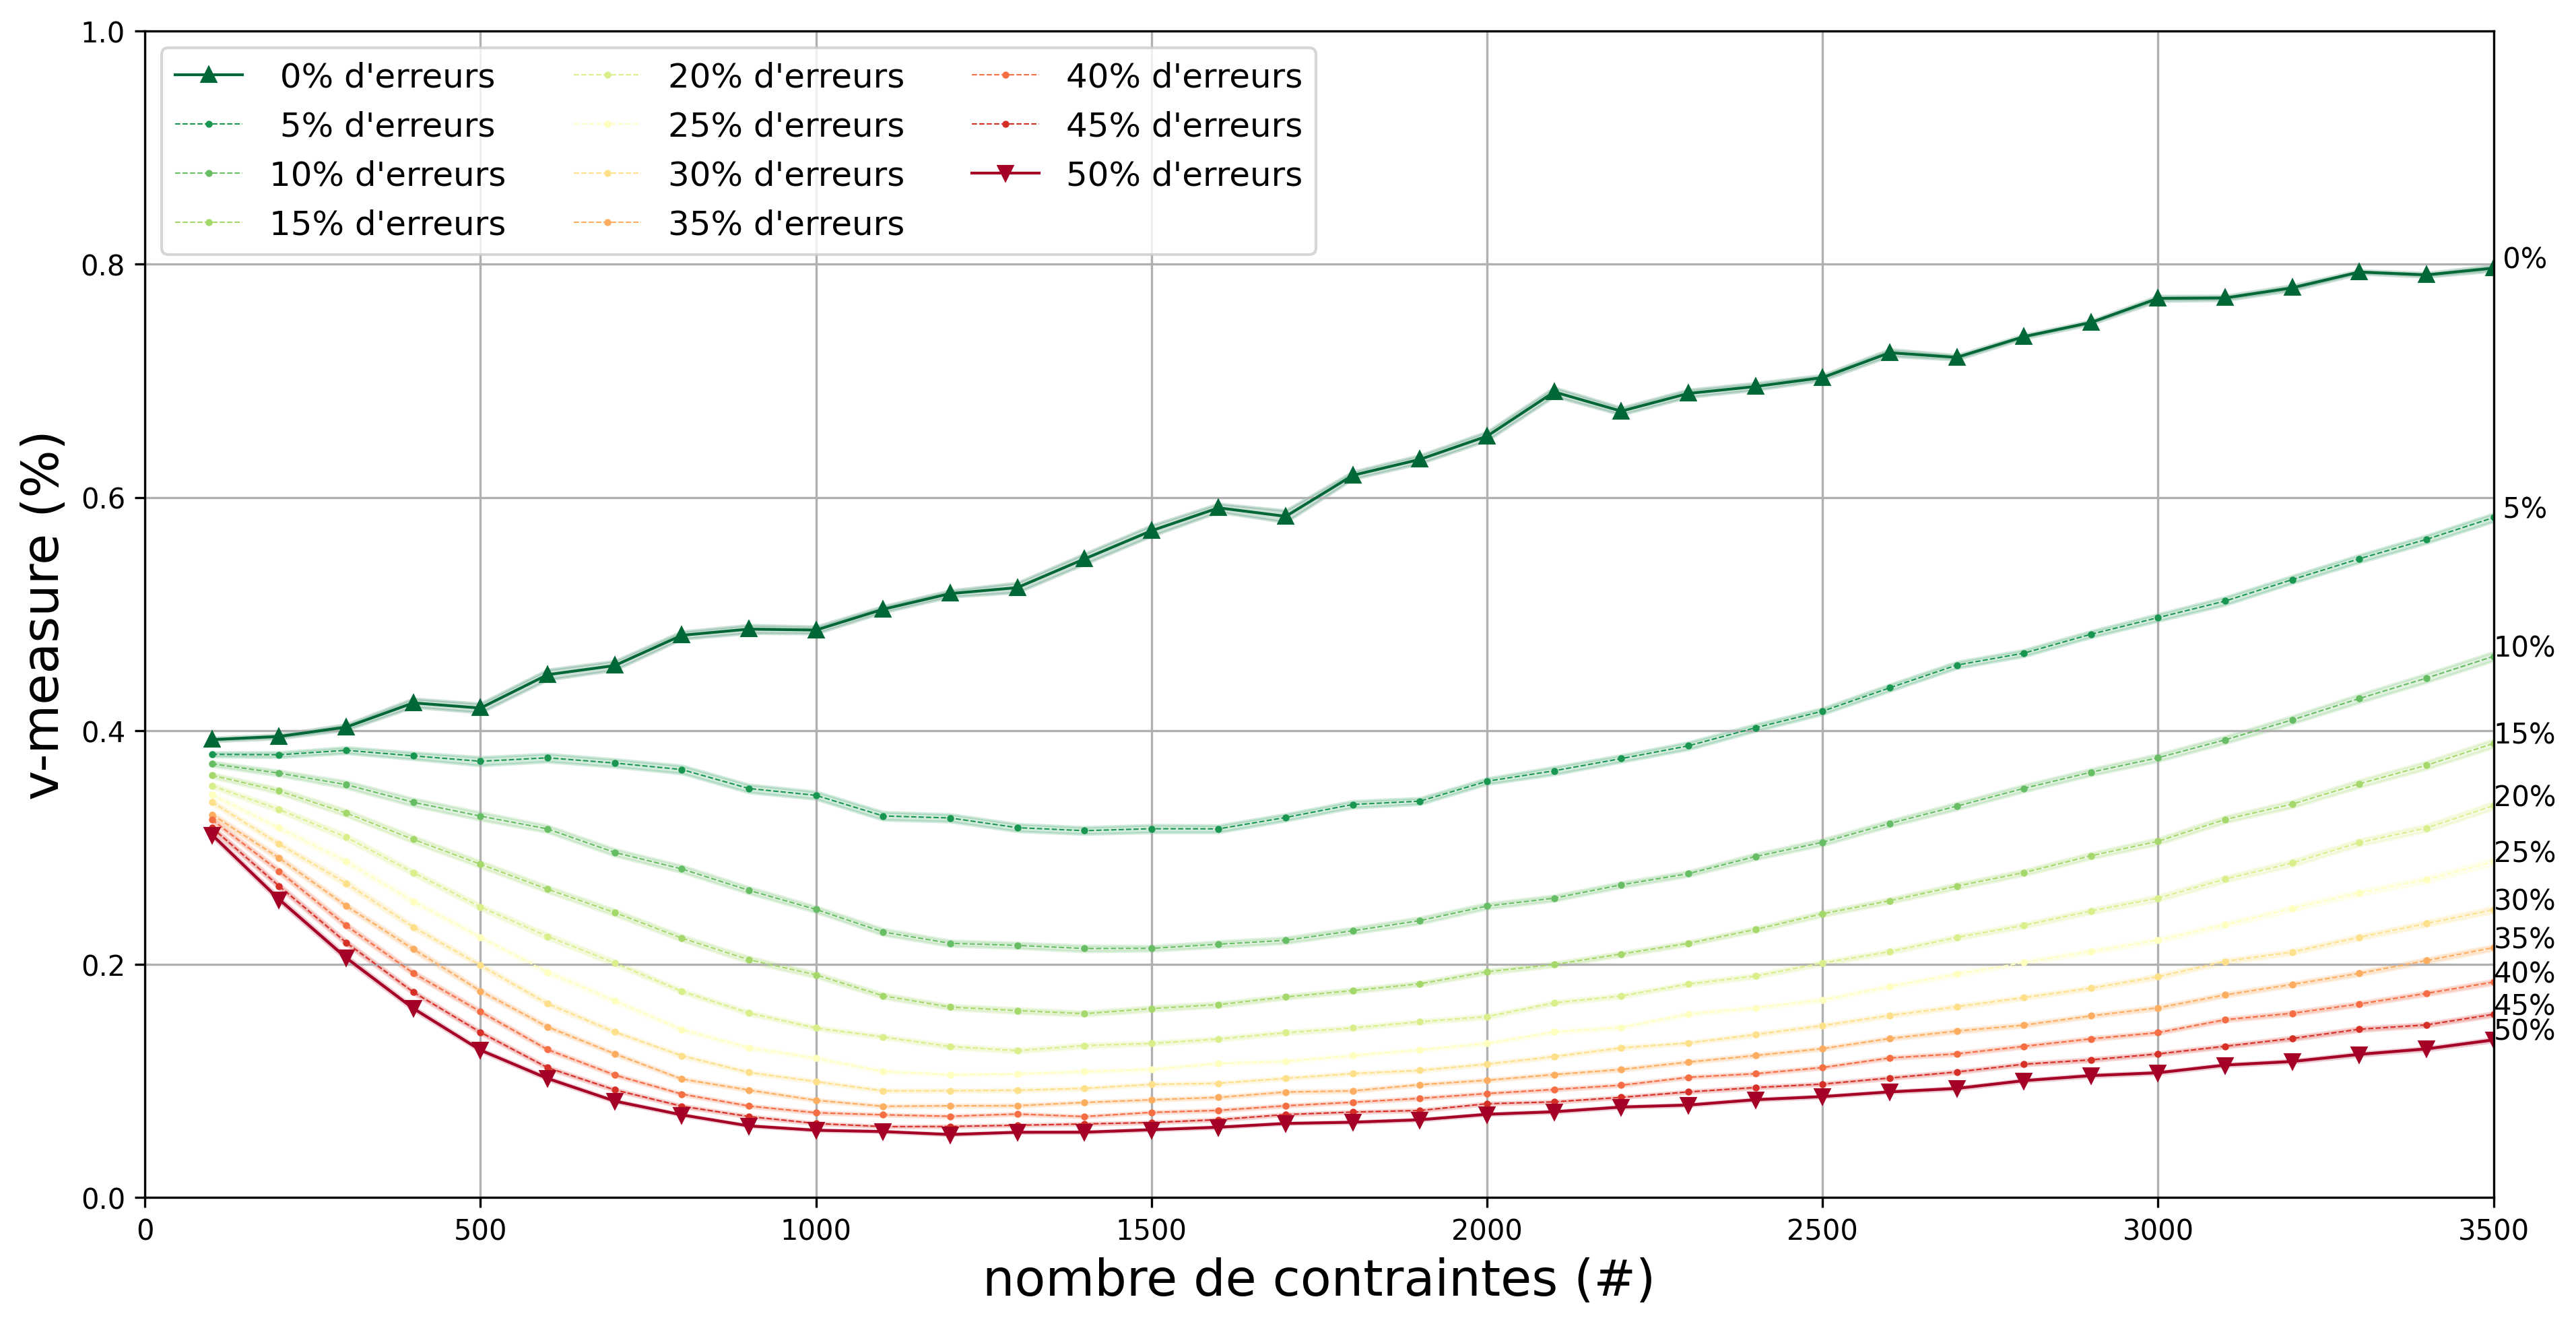

In [20]:
# Create a new figure.
fig_plot_error_simulation_random_with_fix: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_error_simulation_random_with_fix = fig_plot_error_simulation_random_with_fix.gca()

# Set range of axis.
axis_plot_error_simulation_random_with_fix.set_xlim(xmin=0, xmax=MAX_NB_CONSTRAINTS_TO_PLOT)
axis_plot_error_simulation_random_with_fix.set_ylim(ymin=0, ymax=1)

# Define color map.
list_of_colors = matplotlib.colormaps["RdYlGn"](
    np.linspace(1, 0, len(LIST_OF_ERROR_RATES))
)
    
# Plot error simulation.
for k, error_rate_k in enumerate(LIST_OF_ERROR_RATES):
        
    # Compute performance MEAN and SEM for this error rate.
    performances_random_with_fix_MEAN, performances_random_with_fix_SEM = get_MEAN_SEM_of_performance_evolution_per_constraints_number(
        local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
            env
            for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
            if (
                "-rand_" in env.split("/")[4]
                and "{rate:.2f}".format(rate=error_rate_k) in env.split("/")[5]
                and "-with_fix" in env.split("/")[5]
            )
        ],
    )
    
    # Add plot.
    add_plot_of_performance_evolution_per_constraints_number_to_graph(
        axis=axis_plot_error_simulation_random_with_fix,
        list_of_x=[
            constraints_number
            for constraints_number in sorted(performances_random_with_fix_MEAN.keys())
            if constraints_number <= MAX_NB_CONSTRAINTS_TO_PLOT
        ],
        dict_of_y=performances_random_with_fix_MEAN,
        dict_of_y_err=performances_random_with_fix_SEM,
        label="{rate:2d}% d'erreurs".format(rate=int(error_rate_k*100)),
        label_in_curve="{rate:2d}%".format(rate=int(error_rate_k*100)),
        marker=markers[error_rate_k],
        markersize=markersizes[error_rate_k],
        color=list_of_colors[k],
        linewidth=linewidths[error_rate_k],
        linestyle=linestyles[error_rate_k],
        alpha=0.2,
    )

# Set axis name.
axis_plot_error_simulation_random_with_fix.set_xlabel("nombre de contraintes (#)", fontsize=18,)
axis_plot_error_simulation_random_with_fix.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_error_simulation_random_with_fix.legend(
    ncol=3,
    loc="upper left",
    fontsize=12,
)

# Plot the grid.
axis_plot_error_simulation_random_with_fix.grid(True)
    
# Store the graph.
fig_plot_error_simulation_random_with_fix.savefig(
    "../results/etude-erreur-simulation-impact-2random-with-fix.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)

Modelization of `closest_in_different_clusters` `with_fix=True`.

In [21]:
# Fit the model to the data and print results.
model_simulation_closest_with_fix = statsmodels.formula.api.glm(
    formula="clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate",
    data=df_simulations[
        (df_simulations["constraints_selection__algorithm"]=="closest_in_different_clusters")
        &(df_simulations["error_simulation__with_fix"]==True)
    ],
)
results_simulation_closest_with_fix = model_simulation_closest_with_fix.fit()
print("==============================================================================")
print(">>> formula:", model_simulation_closest_with_fix.formula)
print("==============================================================================")
print(results_simulation_closest_with_fix.summary())

>>> formula: clustering__v_measure ~ 1 + constraints__annotated*error_simulation__error_rate
                   Generalized Linear Model Regression Results                   
Dep. Variable:     clustering__v_measure   No. Observations:                27500
Model:                               GLM   Df Residuals:                    27496
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                       0.0075544
Method:                             IRLS   Log-Likelihood:                 28158.
Date:                   Mon, 12 Jun 2023   Deviance:                       207.72
Time:                           17:46:22   Pearson chi2:                     208.
No. Iterations:                        3   Pseudo R-squ. (CS):             0.9981
Covariance Type:               nonrobust                                         
                                                          coef    std err          z   

In [22]:
print(
    "closest.with_fix ~",
    "{0:.2E}".format(results_simulation_closest_with_fix.params["Intercept"]),
    "+ {0:.2E}*constraints".format(results_simulation_closest_with_fix.params["constraints__annotated"]),
    "+ {0:.2E}*error_rate".format(results_simulation_closest_with_fix.params["error_simulation__error_rate"]),
)

closest.with_fix ~ 5.06E-01 + 2.16E-04*constraints + -7.18E-01*error_rate


In [23]:
# Define the interpolation function.
def interpolation_closest_with_fix(constraints_number, error_rate) -> Tuple[float, float, float]:
    # Initialization.
    res_low: float = 0.0
    res: float = 0.0
    res_high: float = 0.0
    # Intercept.
    res_low += (results_simulation_closest_with_fix.params["Intercept"] - results_simulation_closest_with_fix.bse["Intercept"])
    res += results_simulation_closest_with_fix.params["Intercept"]
    res_high += (results_simulation_closest_with_fix.params["Intercept"] + results_simulation_closest_with_fix.bse["Intercept"])
    # constraints__annotated.
    res_low += (results_simulation_closest_with_fix.params["constraints__annotated"] - results_simulation_closest_with_fix.bse["constraints__annotated"]) * constraints_number
    res += results_simulation_closest_with_fix.params["constraints__annotated"] * constraints_number
    res_high += (results_simulation_closest_with_fix.params["constraints__annotated"] + results_simulation_closest_with_fix.bse["constraints__annotated"]) * constraints_number
    # error_simulation__error_rate.
    res_low += (results_simulation_closest_with_fix.params["error_simulation__error_rate"] - results_simulation_closest_with_fix.bse["error_simulation__error_rate"]) * error_rate
    res += results_simulation_closest_with_fix.params["error_simulation__error_rate"] * error_rate
    res_high += (results_simulation_closest_with_fix.params["error_simulation__error_rate"] + results_simulation_closest_with_fix.bse["error_simulation__error_rate"]) * error_rate
    # Return.
    return res_low, res, res_high

In [ ]:
# Create a new figure.
fig_plot_error_simulation_closest_with_fix: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_error_simulation_closest_with_fix = fig_plot_error_simulation_closest_with_fix.gca()

# Set range of axis.
axis_plot_error_simulation_closest_with_fix.set_xlim(xmin=0, xmax=MAX_NB_CONSTRAINTS_TO_PLOT)
axis_plot_error_simulation_closest_with_fix.set_ylim(ymin=0, ymax=1)

# Define color map.
list_of_colors = matplotlib.colormaps["RdYlGn"](
    np.linspace(1, 0, len(LIST_OF_ERROR_RATES))
)
    
# Plot error simulation.
for k, error_rate_k in enumerate(LIST_OF_ERROR_RATES):
        
    # Compute performance MEAN and SEM for this error rate.
    performances_closest_with_fix_MEAN, performances_closest_with_fix_SEM = get_MEAN_SEM_of_performance_evolution_per_constraints_number(
        local_LIST_OF_EXPERIMENT_ENVIRONMENTS=[
            env
            for env in LIST_OF_EXPERIMENT_ENVIRONMENTS
            if (
                "-closest_" in env.split("/")[4]
                and "{rate:.2f}".format(rate=error_rate_k) in env.split("/")[5]
                and "-with_fix" in env.split("/")[5]
            )
        ],
    )
    
    # Add plot.
    add_plot_of_performance_evolution_per_constraints_number_to_graph(
        axis=axis_plot_error_simulation_closest_with_fix,
        list_of_x=[
            constraints_number
            for constraints_number in sorted(performances_closest_with_fix_MEAN.keys())
            if constraints_number <= MAX_NB_CONSTRAINTS_TO_PLOT
        ],
        dict_of_y=performances_closest_with_fix_MEAN,
        dict_of_y_err=performances_closest_with_fix_SEM,
        label="{rate:2d}% d'erreurs".format(rate=int(error_rate_k*100)),
        label_in_curve="{rate:2d}%".format(rate=int(error_rate_k*100)),
        marker=markers[error_rate_k],
        markersize=markersizes[error_rate_k],
        color=list_of_colors[k],
        linewidth=linewidths[error_rate_k],
        linestyle=linestyles[error_rate_k],
        alpha=0.2,
    )

# Set axis name.
axis_plot_error_simulation_closest_with_fix.set_xlabel("nombre de contraintes (#)", fontsize=18,)
axis_plot_error_simulation_closest_with_fix.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot_error_simulation_closest_with_fix.legend(
    ncol=3,
    loc="upper left",
    fontsize=12,
)

# Plot the grid.
axis_plot_error_simulation_closest_with_fix.grid(True)
    
# Store the graph.
fig_plot_error_simulation_closest_with_fix.savefig(
    "../results/etude-erreur-simulation-impact-2closest-with-fix.png",
    dpi=300,
    transparent=True,
    bbox_inches="tight",
)